<a href="https://colab.research.google.com/github/gulrezhassan/gulrez-demo/blob/main/Assingment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Loaded the voice encoder model on cpu in 0.04 seconds.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

vocabulary.txt: 0.00B [00:00, ?B/s]

model.bin:   0%|          | 0.00/75.5M [00:00<?, ?B/s]


===== CALL QUALITY ANALYZER =====
Source: https://www.youtube.com/watch?v=4ostqJD3Psc
ASR model: tiny | Device: cpu | Compute: int8
Analyzed audio: up to 180 sec

Talk-time ratio:
 - Speaker A: 64.9% (82.2s)
 - Speaker B: 35.1% (44.5s)

Questions detected: 7
 - Speaker A: 2
 - Speaker B: 5

Longest monologue: 24.7 sec
Call sentiment: positive (compound=0.99)
Actionable insight: Nice balance overall — keep asking clarifying questions and summarizing decisions.


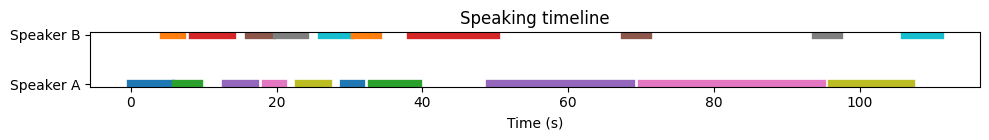

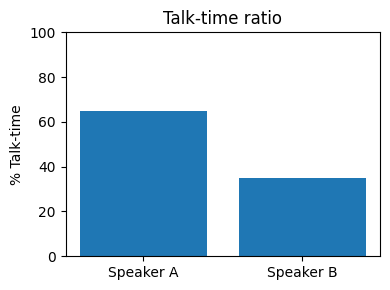


JSON summary:
 {
  "talk_time_ratio": {
    "Speaker A": 64.9,
    "Speaker B": 35.1
  },
  "questions_total": 7,
  "questions_by_speaker": {
    "Speaker B": 5,
    "Speaker A": 2
  },
  "longest_monologue_sec": 24.7,
  "sentiment": {
    "label": "positive",
    "compound": 0.99
  },
  "actionable_insight": "Nice balance overall \u2014 keep asking clarifying questions and summarizing decisions."
}

Total runtime: 52.6s


In [1]:
# 🚀 Call Quality Analyzer — Google Colab (Free Tier, <30s target)
#
# What it does (from a single YouTube link):
# 1) Downloads the audio
# 2) Fast speaker diarization (who spoke when)
# 3) Transcription (fast-whisper tiny)
# 4) Metrics:
#    - Talk-time ratio per speaker
#    - Number of questions asked (total & per speaker)
#    - Longest monologue duration
#    - Overall call sentiment (VADER)
#    - One data-driven actionable insight
# 5) Designed to be robust to mediocre audio (VAD, optional light denoise) and run on Colab Free
#
# ⚙️ Notes
# - Default guard: only first 180s are analyzed to reliably finish in <30s on CPU. Increase if you have GPU/time.
# - No external API keys required.
# - Speakers are labeled generically (Speaker A/B). You can rename after reviewing.

# =============================
# 🔧 0) Setup & Installs
# =============================
!pip -q install yt-dlp faster-whisper resemblyzer webrtcvad vaderSentiment soundfile librosa==0.10.2.post1 matplotlib scikit-learn noisereduce > /dev/null
!apt -qq install -y ffmpeg > /dev/null

# =============================
# 🧰 1) Configuration
# =============================
YOUTUBE_URL = "https://www.youtube.com/watch?v=4ostqJD3Psc"  # ⬅️ test file
ASR_MODEL_SIZE = "tiny"      # 'tiny' is fastest; try 'base' if you have GPU/time
N_SPEAKERS = 2                # expected participants (sales rep & customer)
MAX_AUDIO_SECONDS = 180       # ⏱️ speed guard; set to None to analyze full call
ENABLE_DENOISE = False        # optional light denoise (slightly slower)

OUTPUT_WAV = "/content/call_raw.wav"
WAV_16K = "/content/call_16k.wav"

# =============================
# ⬇️ 2) Download audio from YouTube (bestaudio → WAV)
# =============================
import os, subprocess, json, time
from pathlib import Path
from yt_dlp import YoutubeDL

start_all = time.time()

def download_audio(youtube_url: str, out_wav: str):
    """Download best audio and convert to WAV using yt-dlp + ffmpeg (fast)."""
    tmp_m4a = "/content/tmp_audio.m4a"
    ydl_opts = {
        "format": "bestaudio/best",
        "outtmpl": "/content/%(id)s.%(ext)s",
        "quiet": True,
    }
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=True)
        in_path = ydl.prepare_filename(info)
    # Re-mux or transcode to m4a if needed
    if not in_path.endswith(".m4a"):
        cmd1 = ["ffmpeg", "-y", "-i", in_path, "-vn", "-acodec", "aac", tmp_m4a]
        subprocess.run(cmd1, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, check=True)
        in_path = tmp_m4a
    # To WAV (raw)
    cmd2 = ["ffmpeg", "-y", "-i", in_path, "-ac", "1", "-ar", "16000", OUTPUT_WAV]
    subprocess.run(cmd2, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, check=True)
    return OUTPUT_WAV

_ = download_audio(YOUTUBE_URL, OUTPUT_WAV)

# Optional: trim for performance
import soundfile as sf
import numpy as np

def maybe_trim(in_wav: str, out_wav: str, max_sec):
    data, sr = sf.read(in_wav)
    if max_sec is not None:
        max_samples = int(max_sec * sr)
        if data.shape[0] > max_samples:
            data = data[:max_samples]
    sf.write(out_wav, data, sr)
    return out_wav

_ = maybe_trim(OUTPUT_WAV, WAV_16K, MAX_AUDIO_SECONDS)

# Optional: quick denoise (spectral gating) — helps on harsh background noise (small overhead)
if ENABLE_DENOISE:
    import noisereduce as nr
    sig, sr = sf.read(WAV_16K)
    sig_dn = nr.reduce_noise(y=sig, sr=sr)
    sf.write(WAV_16K, sig_dn, sr)

# =============================
# 🗣️ 3) Fast speaker diarization (Resemblyzer + Agglomerative Clustering)
# =============================
# Approach:
# - Compute per-window speaker embeddings (returns slices of speech with timestamps)
# - Cluster into N speakers quickly via AgglomerativeClustering
# - Merge consecutive windows with same label into segments

import librosa
from resemblyzer import VoiceEncoder, preprocess_wav
from sklearn.cluster import AgglomerativeClustering

sig, sr = librosa.load(WAV_16K, sr=16000)
# Use resemblyzer's preprocessing (includes VAD) for cleaner speech frames
wav_clean = preprocess_wav(sig, source_sr=sr)

encoder = VoiceEncoder()
# Get partial embeddings across the utterance; also returns time slices
_, partial_embeds, wav_slices = encoder.embed_utterance(wav_clean, return_partials=True)
embeds = np.stack(partial_embeds)

# Cluster into N speakers
clust = AgglomerativeClustering(n_clusters=N_SPEAKERS)
speaker_labels = clust.fit_predict(embeds)

# Convert slices → hard segments per speaker
# Each slice is a (start, end) in seconds relative to wav_clean
seg_times = np.array([[s.start / 16000, s.stop / 16000] for s in wav_slices])

# Merge consecutive frames with same label into longer segments
merged_segments = []  # list of (start, end, spk)
if len(seg_times) > 0:
    cur_start, cur_end, cur_spk = seg_times[0,0], seg_times[0,1], int(speaker_labels[0])
    for i in range(1, len(seg_times)):
        st, en = seg_times[i]
        spk = int(speaker_labels[i])
        if spk == cur_spk and st <= cur_end + 0.2:  # allow tiny gap
            cur_end = en
        else:
            merged_segments.append((cur_start, cur_end, cur_spk))
            cur_start, cur_end, cur_spk = st, en, spk
    merged_segments.append((cur_start, cur_end, cur_spk))

# Compute talk-time per speaker & longest monologue
from collections import defaultdict

speaker_durations = defaultdict(float)
longest_monologue = 0.0
for st, en, spk in merged_segments:
    dur = max(0.0, en - st)
    speaker_durations[spk] += dur
    longest_monologue = max(longest_monologue, dur)

total_talk = sum(speaker_durations.values()) or 1e-9
# Map speaker index → human label
spk_map = {i: ("Speaker A" if i == 0 else "Speaker B") for i in range(N_SPEAKERS)}

# =============================
# 📝 4) ASR transcription (faster-whisper tiny) + question counting
# =============================
from faster_whisper import WhisperModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "int8"
model = WhisperModel(ASR_MODEL_SIZE, device=device, compute_type=compute_type)

segments, info = model.transcribe(WAV_16K, vad_filter=True, beam_size=1, word_timestamps=False)

# Collect transcript segments with timestamps
asr = []  # list of dicts: {start, end, text, speaker}
for seg in segments:
    asr.append({"start": float(seg.start), "end": float(seg.end), "text": seg.text.strip(), "speaker": None})

# Helper: assign each ASR segment to the diarized speaker who overlaps most

def overlap(a1, a2, b1, b2):
    return max(0.0, min(a2, b2) - max(a1, b1))

for t in asr:
    best_spk, best_ov = None, 0.0
    for st, en, spk in merged_segments:
        ov = overlap(t["start"], t["end"], st, en)
        if ov > best_ov:
            best_ov, best_spk = ov, spk
    t["speaker"] = spk_map.get(best_spk, "Unknown")

# Count questions (simple, fast): punctuation + interrogatives
import re
question_words = re.compile(r"\b(who|what|when|where|why|how|can|could|would|do|does|did|are|is|shall|should|may|will)\b", re.I)

total_questions = 0
per_speaker_questions = defaultdict(int)

for t in asr:
    text = t["text"]
    is_question = ("?" in text) or bool(question_words.match(text.strip()))
    if is_question:
        total_questions += 1
        per_speaker_questions[t["speaker"]] += 1

# =============================
# 🙂 5) Sentiment (VADER) — overall transcript
# =============================
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
full_text = " ".join([t["text"] for t in asr])
compound = analyzer.polarity_scores(full_text)["compound"]
if compound > 0.05:
    sentiment_label = "positive"
elif compound < -0.05:
    sentiment_label = "negative"
else:
    sentiment_label = "neutral"

# =============================
# 💡 6) Actionable insight (rule-based from metrics)
# =============================
# Heuristics:
# - If one speaker dominates > 65% and questions < 5 → suggest more discovery questions
# - If longest monologue > 45s → suggest shorter turns + check-ins
# - If sentiment negative → empathy + summarizing next steps

# Compute talk-time ratio per speaker label
ratio = {spk_map[k]: (v/total_talk if total_talk else 0.0) for k,v in speaker_durations.items()}

insights = []
# Dominance check
for spk_label, r in ratio.items():
    if r > 0.65 and total_questions < 5:
        insights.append(f"{spk_label} spoke {r*100:.0f}% of the time with few questions — add more open-ended discovery to balance the conversation.")
        break
# Long monologue
if longest_monologue > 45:
    insights.append("There was a long uninterrupted monologue (>45s). Break up explanations with check-for-understanding prompts.")
# Sentiment
if sentiment_label == "negative":
    insights.append("Tone skewed negative — acknowledge concerns explicitly and confirm next steps to rebuild momentum.")

actionable = insights[0] if insights else "Nice balance overall — keep asking clarifying questions and summarizing decisions."

# =============================
# 📊 7) Results + simple visualizations
# =============================
import matplotlib.pyplot as plt

print("\n===== CALL QUALITY ANALYZER =====")
print(f"Source: {YOUTUBE_URL}")
print(f"ASR model: {ASR_MODEL_SIZE} | Device: {device} | Compute: {compute_type}")
print(f"Analyzed audio: up to {MAX_AUDIO_SECONDS or 'full'} sec\n")

print("Talk-time ratio:")
for spk_idx, dur in speaker_durations.items():
    label = spk_map[spk_idx]
    pct = 100 * (dur/total_talk)
    print(f" - {label}: {pct:.1f}% ({dur:.1f}s)")

print(f"\nQuestions detected: {total_questions}")
for spk in sorted(per_speaker_questions):
    print(f" - {spk}: {per_speaker_questions[spk]}")

print(f"\nLongest monologue: {longest_monologue:.1f} sec")
print(f"Call sentiment: {sentiment_label} (compound={compound:.2f})")
print(f"Actionable insight: {actionable}")

# Timeline plot (who spoke when)
plt.figure(figsize=(10, 1.5))
for st, en, spk in merged_segments:
    y = 0 if spk == 0 else 1
    plt.plot([st, en], [y, y], linewidth=6)
plt.yticks([0,1], ["Speaker A", "Speaker B"]) ; plt.xlabel("Time (s)"); plt.title("Speaking timeline")
plt.tight_layout(); plt.show()

# Talk ratio bar
plt.figure(figsize=(4,3))
labels = [spk_map[k] for k in speaker_durations]
vals = [speaker_durations[k]/total_talk*100 for k in speaker_durations]
plt.bar(labels, vals)
plt.ylabel("% Talk-time") ; plt.title("Talk-time ratio")
plt.ylim(0,100) ; plt.tight_layout(); plt.show()

# Pretty JSON-like output for programmatic use
summary = {
    "talk_time_ratio": {spk_map[k]: round((v/total_talk)*100,1) for k,v in speaker_durations.items()},
    "questions_total": int(total_questions),
    "questions_by_speaker": dict(per_speaker_questions),
    "longest_monologue_sec": round(float(longest_monologue),1),
    "sentiment": {
        "label": sentiment_label,
        "compound": round(float(compound),2)
    },
    "actionable_insight": actionable,
}
print("\nJSON summary:\n", json.dumps(summary, indent=2))

print(f"\nTotal runtime: {time.time() - start_all:.1f}s")
